In [1]:
from pydub import AudioSegment
from scipy.io import wavfile
import IPython
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_random_time_segment(segment_ms):
    if segment_ms >= 5000:
        return -1
    
    segment_start = np.random.randint(low=0, high=5000-segment_ms)
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

#### get_random_time_segment(segment_ms):
* segment_ms 길이의 오디오 클립을 삽입할 수 있는 임의의 시간 세그먼트를 반환.

## - Check if audio clips are overlapping

* 세그먼트 (1000,1800) 및 (3400,4500)에 오디오 클립을 삽입했다고 가정
    * 첫 번째 세그먼트는 1000ms에서 시작하여 1800ms에서 끝
    * 두 번째 세그먼트는 3400ms에서 시작하여 4500ms에서 끝
* (3000,3600)에 새 오디오 클립을 삽입할지 여부를 고려하고 있다면? 
    * 이 경우 (3000,3600)과 (3400,4500)이 겹치므로 여기에 클립을 삽입하지 않도록 결정

In [3]:
def is_overlapping(segment_time, previous_segments):
    if segment_time == -1:
        return True 
    
    segment_start, segment_end = segment_time
    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

#### is_overlapping(segment_time, existing_segments):
* 삽입될 세그먼트가 이전 세그먼트와 겹치는지 확인

* 다음 2개의 step이 필요
    * 1) "False"플래그를 생성. 겹치는 부분이있는 경우 나중에 "True"로 설정.
    * 2) 모든 previous_segments를 반복하여 삽입될 세그먼트와 비교. 겹치는 부분이 발생하면 1) 설정

## - Insert audio clip

* 이전 helper function을 사용하여 10초의 background noise에 임의의 시간에 오디오 클립을 삽입
* 새로 삽입될 세그먼트가 이전에 삽입된 세그먼트와 겹치지 않도록 함

In [4]:
def insert_audio_clip(background, audio_clip, previous_segments):  
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    count = 1
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)
        
        count +=1
        if count == 3:
            return -1, -1

    previous_segments.append(segment_time)
    
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

#### def insert_audio_clip(): 
* 아래 4개의 단계가 필요

    * 1) 삽입할 오디오 클립의 시간의 시간 세그먼트를 가져 옴
    * 2) 시간 세그먼트가 이전 시간 세그먼트와 겹치지 않는지 확인
    * 3) 새 시간 세그먼트를 기존 시간 세그먼트 목록에 추가
    * 4) pydub을 사용하여 background noise에 오디오 클립을 삽입

#### [insert_audio_clip example]

In [5]:
background = AudioSegment.from_wav("data/Training/Background/bg1.wav")
activate = AudioSegment.from_wav("data/Training/Positive/message/jmk_7.wav")

np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(background, activate, [])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 3226)


## - Insert ones for the labels of the target audio

* $y^{\langle t \rangle}$ 라벨은 "Positive" 오디오의 여부를 나타냄 
    * $y^{\langle t \rangle} = 1$ 해당 클립이 "Positive" 면 1
    * $y^{\langle t \rangle}=0$ for all $t$, Background noise에는 "Positive"가 없기 때문에 0으로 초기화 
* "Positive" 오디오 클립이 Background noise에 삽입되면 $y^{\langle t \rangle}$. 또한 업데이트
    * 1개의 time step을 1로 업데이트 하지 않고 삽입된 위치 중간 부터 끝 뒤 연속된 10개의 time step을 1로 업데이트 
    
    
    
    
* 만약 세그먼트가 `segment_end_ms` 에서 끝이 나면
    * 196개의 $y$ (using a $196$ step discretization)를 ms 단위로 변환하려면,  
```
    segment_end_y = int(segment_end_ms * Ty / 5000.0)
```

<img src="img/Fig1.png" style="width:500px;height:200px;">

In [6]:
# Ty는 검출 모델에서 Convolution layer의 아웃 풋 갯수
Ty = 196 # The number of time steps in the output of our model

In [7]:
def insert_ones(y, segment_start_ms, segment_end_ms):
    segment_start_y = int(segment_start_ms * Ty / 5000.0)
    segment_end_y = int(segment_end_ms * Ty / 5000.0)
    
    for i in range( int((segment_start_y + segment_end_y)/2) , segment_end_y + 10):
        if i < len(y[0]):
            y[0, i] = 1
    
    return y

#### def insert_ones(): 
* $y^{\langle t \rangle}$를 업데이트 하는 코드 구현업데이트 하는 코드 구현,
* `y` 는 `(1,196)` dimension의 벡터, 따라서, $T_y = 196$. 
* 만약 오디오 클립이 시간 $s_t$ 에 시작되고 $e_t$에 끝나면, $y^{\langle (s_t + e_t) / 2 \rangle} = 1$ 으로 설정, 그리고 이어지는 $e_t$+10개 까지의 연속된 값 또한 1로 설정.
    * 만약 삽입될 오디오가 5초의 background noise 끝 부분 근처에 나타나면 1로 설정할  벡터가 10개가 없을 수 도 있음.
    * 배열의 끝을 벗어나지 않도록 `y[0][196]`를 업데이트
    * 만약 "positive"가 190 위치에 삽입되면 `y[0][190] = y[0][191] = y[0][192] = ... = y[0][195] = 1`

#### [insert_ones example]

In [8]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


checks: 1.0 0.0 0.0


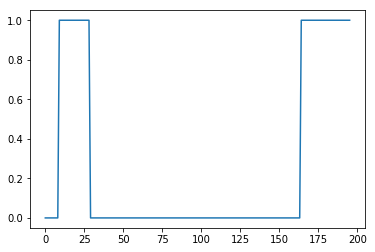

In [9]:
arr1 = insert_ones(np.zeros((1, Ty)), 0, 500)
plt.plot(insert_ones(arr1, 3421, 4999)[0,:])
print("checks:", arr1[0][10], arr1[0][30], arr1[0][100])

#### [Create training data example]

In [10]:
background = AudioSegment.from_wav("data/Training/Background/bg1.wav")
positive = AudioSegment.from_wav("data/Training/Positive/message/jmk_7.wav")

In [11]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(background, activate, [])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)

IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 3226)


Segment start:  114
Segment end:  126


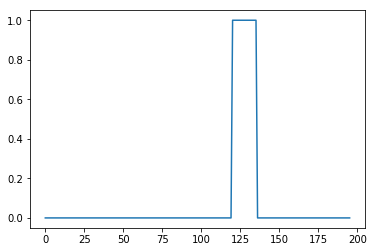

In [12]:
arr1 = np.zeros((1, Ty))
plt.plot(insert_ones(arr1, segment_time[0],segment_time[1])[0,:])

print("Segment start: ", int(segment_time[0] * Ty / 5000.0))
print("Segment end: ", int(segment_time[1] * Ty / 5000.0))

## - Create training data examples

* 마지막으로 `insert_audio_clip` 와 `insert_ones` 를 사용하여 학습 예제들을 생성할 수 있음

* `create_training_example()` 구현. 

1) Label 벡터 $y$를 $(1, T_y)$ shape을 갖는 벡터로 구성하고 0으로 초기화

2) 세그먼트 목록을 empty list로 할당

3) 50% 확률로 "Negative"를 삽입 할지, 삽입한다면 0~2개 Random하게 삽입

4) 임의로 "Positive" 오디오 클립을 선택하고 5초의 Background noise에 삽입. 또한, $y$ 의 올바른 위치에 Label을 삽입

In [17]:
def load_audio_files(mode):
    activates = []
    backgrounds = []
    negatives = []
    
    for filename in os.listdir("data/"+mode+"/Background"):
        if filename.endswith("wav"):
            backgrounds.append("data/"+mode+"/Background/"+filename)
            
    for direc in os.listdir("data/"+mode+"/Positive"):
        for filename in os.listdir("data/"+mode+"/Positive/"+direc):
            if filename.endswith("wav"):
                activates.append("data/"+mode+"/Positive/"+direc + "/" + filename)                
                    
    for direc in os.listdir("data/"+mode+"/Negative"):
        for filename in os.listdir("data/"+mode+"/Negative/"+direc):
            if filename.endswith("wav"):
                negatives.append("data/"+mode+"/Negative/"+direc + "/" + filename)
    
    return activates, negatives, backgrounds

def create_training_example(background, activates, negatives, filename = "train.wav"):
    background_audio = AudioSegment.from_wav(background)
    
    y = np.zeros([1,Ty])
    
    previous_segments = []
    
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for random_activate in random_activates:
        activate_audio = AudioSegment.from_wav(random_activate)
        
        return_audio, segment_time = insert_audio_clip(background_audio, activate_audio, previous_segments)
                
        if return_audio == -1:
            continue
        else:
            background_audio = return_audio
        
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_start, segment_end)
        
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]    
    
    for random_negative in random_negatives:
        negative_audio = AudioSegment.from_wav(random_negative)
        
        return_audio, segment_time = insert_audio_clip(background_audio, negative_audio, previous_segments)
        
        if return_audio == -1:
            continue
        else:
            background_audio = return_audio
        
    file_handle = background_audio.export(filename, format="wav")
    
    return background_audio, y

In [18]:
positives, negatives, backgrounds = load_audio_files("Training")

print("#background: " + str(len(backgrounds)))   
print("#positive: " + str(len(positives)))    
print("#negative: " + str(len(negatives)))     

#background: 10
#positive: 150
#negative: 95


In [108]:
number_of_training = 500

train_y = []
train_x = []

# Training Data 합성 및 저장
for i in range(number_of_training):
    random_indice = np.random.randint(len(backgrounds), size=1)[0]
    
    filename = "../Data2/Training/train"+str(i)+".wav"
    
    x, y = create_training_example(backgrounds[random_indice], positives, negatives,filename)
    
    train_y.extend(y)
    train_x.append(filename)
    
# Training 파일명 및 라벨 저장
train_y = np.array(train_y)
train_x = np.array(train_x)

idxs = np.arange(train_x.shape[0])
np.random.shuffle(idxs)

train_y = train_y[idxs]
train_x = train_x[idxs]

print(np.shape(train_y))
print(np.shape(train_x))

np.save("../Data2/TrainingLabels.npy",train_y)
np.save("../Data2/TrainingFiles.npy",train_x)

(500, 196)
(500,)


#### [Check training data]

In [109]:
def graph_spectrogram(wav_file):
    fs, data = wavfile.read(wav_file)
    nfft = 255
    noverlap = 155
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx.T

In [120]:
idx = 0
print(train_x[idx])

../Data2/Training/train143.wav


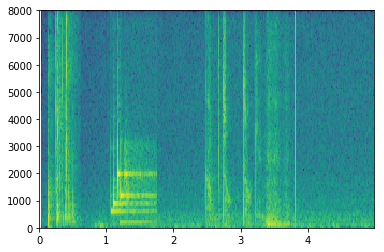

In [115]:
x = graph_spectrogram(train_x[idx])

In [116]:
IPython.display.Audio(train_x[idx])

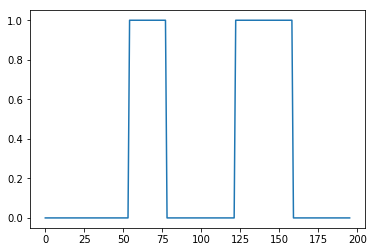

In [117]:
plt.plot(train_y[idx])

## - Create test data examples

In [19]:
positives, negatives, backgrounds = load_audio_files("Test")

print("#background: " + str(len(backgrounds)))
print("#positive: " + str(len(positives)))
print("#negative: " + str(len(negatives)))

#background: 10
#positive: 91
#negative: 57


In [21]:
number_of_test = 100

test_y = []
test_x = []

# Training Data 합성 및 저장
for i in range(number_of_test):
    random_indice = np.random.randint(len(backgrounds), size=1)[0]
    
    filename = "../Data2/Test/test"+str(i)+".wav"
    
    x, y = create_training_example(backgrounds[random_indice], positives, negatives,filename)
    
    test_y.extend(y)
    test_x.append(filename)
    
# Training 파일명 및 라벨 저장
test_y = np.array(test_y)
test_x = np.array(test_x)

idxs = np.arange(test_x.shape[0])
np.random.shuffle(idxs)

test_y = test_y[idxs]
test_x = test_x[idxs]

print(np.shape(test_y))
print(np.shape(test_x))

np.save("../Data2/TestLabels.npy",test_y)
np.save("../Data2/TestFiles.npy",test_x)

(100, 196)
(100,)
